# Nearest Neighbor Classifier Implementation

The objective of this notebook is to do an implementation of one of the simplest machine learning methods: [Nearest neighbor classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm). 

Given a training set of n training examples each with d features and known class label, the nearest neighbor classifier works by finding the eculidean distance of a test example whose class label is not known with all examples in the training set and assigning the label of the nearest training example to the test example. Essentially, it predicts the class label of a test example based on the label of its closest (or least dissimilar) training example. A more generic variant of the classifier, called a k-nearest neighbor (kNN) classifier works by predicting the label of a test example based on majority of k-nearest training examples. The nearest neighbor classifier thus becomes a special case of this classifer with k=1.

We will be doing the following tasks:

1. Generating and visualizing some (toy) data
2. Implementing a distance function
3. Implementing a nearest neighbor classifier function and generating predictions for test data
4. Implementing a function to calculate accuracy
5. Using built-in (sklearn) implementation of k-nearest neighbor classifier

# 1. Generating and visualizing data

The getExamples function below will generate a numpy array X which contains n training examples in d = 2 dimensions and a vector y which contains the corresponding binary class labels (+1 or -1) of these examples. The plotit function will simply do a scatter plot of these training examples in the feature space. 

Note that the semantic meaning of the features or the labels is irrelevant here. 

We have used Gaussian random number generation to generate two sets of points: positive class (y=+1) examples centered at  (+1,+1) and negative class (y=-1) examples centered at (-1,-1) in the feature space.

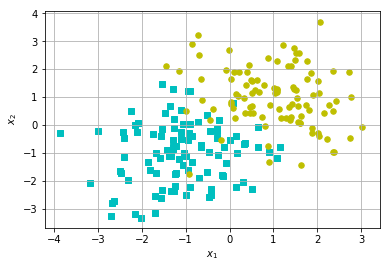

[-3.8565157343533967,
 3.0283945792955023,
 -3.3052030841537854,
 3.6818635272642566]

In [16]:
import numpy as np #importing numpy
from numpy.random import randn,randint #importing randn
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    DO NOT EDIT (from: https://github.com/foxtrotmike/plotit)
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)
        
        z = np.reshape(z,(npts,npts)).T        
        
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()
    return extent

def getExamples(n=100,d=2):
    """
    DO NOT EDIT
    Generates n d-dimensional normally distributed examples of each class        
    The mean of the positive class is [1] and for the negative class it is [-1]
    """
    Xp = randn(n,d)#+1   #generate n examples of the positie class
    Xp=Xp+1
    Xn = randn(n,d)#-1   #generate n examples of the negative class
    Xn=Xn-1
    X = np.vstack((Xp,Xn))  #Stack the examples together to a single matrix
    Y = np.array([+1]*n+[-1]*n) #Associate Labels
    return (X,Y) 


X,Y = getExamples()
plotit(X = X, Y = Y)

# 2. Implementing the Euclidean Distance Function

[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between two vectors $p$ and $q$ in d-dimensional space is given by: $d(p,q) = \sqrt{\sum_{i=1}^{d} (p_i-q_i)^2}$. 

The function below is used to calculate the Euclidean distance between two points. 

In [17]:
def distance(p,q):
    """
    Input:
        p: (1xd) numpy vector of 1 training examples each with d features
        q: (1xd) numpy vector of 1 training examples each with d features        
    Return:
        d: Euclidean Distance
   
    """
    
    d = (((p-q)**2).sum())**0.5

    return d

# 3. Implementing a nearest neighbor function

Here, will be implementing a function implementation of the the nearest neighbor classifier. 

However, before that, we will generate some test data.

In [4]:
# Create train_test split
X_train, X_test = X[:150], X[150:]
y_train, y_test = Y[:150], Y[150:]

In [5]:
def NN(X_train, y_train, X_test):

    list_of_euclidian_distances = []
    list_of_y_pred_indexes = []

    for i in X_test:
        for j in X_train:
            d = distance(i,j)
            list_of_euclidian_distances.append(d)
        # find nearest neighbour
        y_pred_index = list_of_euclidian_distances.index(min(list_of_euclidian_distances))
        list_of_y_pred_indexes.append(y_pred_index)

        #reset list_of_euclidian_distances = []
        list_of_euclidian_distances = []


    y_pred = []

    for i in list_of_y_pred_indexes:
        y_pred.append(y_train[i])
        
    return y_pred



In [6]:
# get y_predictions
y_pred = NN(X_train, y_train, X_test)

In [7]:
# create a dataframe of real vs predicted values

import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame({'real':y_test,'pred':y_pred})
df.head()

,real,pred
0,-1,1
1,-1,-1
2,-1,1
3,-1,-1
4,-1,-1


In [8]:
correct = 0

for i in range(len(df)):
    if df['real'][i] == df['pred'][i]:
        correct+=1
        

In [9]:
correct

40

# 4. Accuracy Claculation

Below is a function that retutns the accuracy of our model. Accuracy is defined as the number of examples for which the prediction label is equal to the test label.

In [10]:
def get_accuracy(df):
    correct = 0
    
    for i in range(len(df)):
        if df['real'][i] == df['pred'][i]:
            correct+=1
    
    accuracy = correct/len(df)
    
    return accuracy
    


In [11]:
accuracy = get_accuracy(df)

print(f'Accuracy: {accuracy}')

Accuracy: 0.8


# 6. Using sk-learn

Our basic implementation of the nearest neighbor classifier is quite inefficient and tedious. Fortunately, Python provides an excellent package called Scikit-Learn which provides a very [efficient tree-based implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) of k-nearest neighbor which is conceptually very similar to our implementation.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
sknn = KNeighborsClassifier(n_neighbors=1)
sknn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [14]:
pred = sknn.predict(X_test)

We can also use the accuracy function that is builtin for Sk-learn to  verify that our implementation generates the same accuracy as the builtin one for the test data.

In [15]:
# Excellent the accuracy of our own NN implementation and the Sklearn version are the same!
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, pred)

accuracy_score(y_test, pred)

0.8